# Lab: Preparing a system for molecular simulation

### Bienvenidos Todos!

#### This lab will familiarize you with code that applies the AMBER 14 force field to proteins, ligands, and other molecules!

In this lab, you will build force field parameters for a protein-ligand system that we have been focusing on, nirmatrelvir in complex with SARS-COV2-Main Protease (MPro). The code for this parameterization [pdb2amber](https://github.com/swillow/pdb2amber), was written by Dr. Soohaeng Yoo Willow, a research assistant professor with Dr. Minh.

It is necessary to prepare an Anaconda environment so Ambertools and Openmm can be used to parameterize molecules.

Run the cell below, it will take a little while to complete.  When it is completed, your session may "crash for an unknown reason."  This is the restarting of the kernel, and is expected.

In [ ]:
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [ ]:
#Install Ambertools, openbabel, and openmm # Skip the second time

!conda install -c conda-forge ambertools openbabel openmm openmmforcefields openff-toolkit pdbfixer pypdb rdkit --yes

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ambertools
    - openbabel
    - openff-toolkit
    - openmm
    - openmmforcefields
    - pdbfixer
    - pypdb
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    

Next, let's make sure the workshop repository is on your Google Drive and up to date.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

GitHub_dir = '/content/drive/MyDrive/GitHub'
import os
if not os.path.isdir(GitHub_dir):
  !mkdir -p {GitHub_dir}

os.chdir(GitHub_dir)
if not os.path.isdir(os.path.join(GitHub_dir,'modelingworkshop')):
  !git clone https://github.com/CCBatIIT/modelingworkshop
else:
  os.chdir(os.path.join(GitHub_dir,'modelingworkshop'))
  !git pull origin main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
From https://github.com/CCBatIIT/modelingworkshop
 * branch            main       -> FETCH_HEAD
Already up to date.


We will also download code to perform the parameterization and the crystal structure from the Protein Data Bank.

In [ ]:
import os
import time

labs_dir = '/content/drive/MyDrive/GitHub/modelingworkshop/labs'
lab_dir = os.path.join(labs_dir, '3-1')
if not os.path.isdir(lab_dir):
  os.mkdir(lab_dir)
os.chdir(lab_dir)

import json
try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol

if not os.path.isdir('./pdb2amber'):
  !git clone https://github.com/swillow/pdb2amber

if not os.path.isfile('./nirmatrelvir.mol2'):
  !scp /content/drive/MyDrive/GitHub/modelingworkshop/labs-complete/2-2/nirmatrelvir.mol2 ./

if not os.path.isfile('7vh8.pdb'):
  !wget https://files.rcsb.org/download/7vh8.pdb

!pwd

Cloning into 'pdb2amber'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 333 (delta 84), reused 104 (delta 42), pack-reused 176
Receiving objects: 100% (333/333), 9.57 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (179/179), done.
--2022-03-16 14:32:50--  https://files.rcsb.org/download/7vh8.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.222
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7vh8.pdb’

7vh8.pdb                [ <=>                ] 254.47K  --.-KB/s    in 0.1s    

2022-03-16 14:32:50 (2.37 MB/s) - ‘7vh8.pdb’ saved [260577]

/content/drive/MyDrive/GitHub/modelingworkshop/labs-complete/3-1


If you see False, please tell the instructor.

si ves False, por favor dice un(a) instructor(a)

In [ ]:
os.path.isfile('7vh8.pdb'), os.path.isdir('./pdb2amber/build_system'), os.path.isfile('nirmatrelvir.mol2')

(True, True, True)

# Part I - Protonating a protein

For the purpose of this lab, we will parameterize the crystal structure of SARS-COV2 Main Protease Omnicron Variant in complex with Nirmatrelvir.

In [ ]:
if not os.path.isfile('7vh8.pdb'):
  !wget https://files.rcsb.org/download/7vh8.pdb

complex_pdb = '7vh8.pdb'

In [ ]:
!grep -e ATOM 7vh8.pdb > 7vh8_protein.pdb

In [ ]:
view = py3Dmol.view()
view.addModel(open('7vh8_protein.pdb', 'r').read(),'pdb')
view.addStyle('stick')
view.setBackgroundColor('black')
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The cell below will provide the usage of pdb2pqr, hydrogens will be added to the protein in the cell after.

In [ ]:
!pip install pdb2pqr -q
!pdb2pqr30 --help | head -n15

     |████████████████████████████████| 207 kB 8.7 MB/s 
     |████████████████████████████████| 98 kB 8.5 MB/s 
     |████████████████████████████████| 575 kB 37.2 MB/s 
usage: pdb2pqr [-h] [--ff {AMBER,CHARMM,PARSE,TYL06,PEOEPB,SWANSON}]
               [--userff USERFF] [--clean] [--nodebump] [--noopt]
               [--keep-chain] [--assign-only]
               [--ffout {AMBER,CHARMM,PARSE,TYL06,PEOEPB,SWANSON}]
               [--usernames USERNAMES] [--apbs-input APBS_INPUT]
               [--pdb-output PDB_OUTPUT] [--ligand LIGAND] [--whitespace]
               [--neutraln] [--neutralc] [--drop-water] [--include-header]
               [--titration-state-method {propka}] [--with-ph PH]
               [-f FILENAMES] [-r REFERENCE] [-c CHAINS] [-i TITRATE_ONLY]
               [-t THERMOPHILES] [-a ALIGNMENT] [-m MUTATIONS] [-p PARAMETERS]
               [--log-level {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [-o PH]
               [-w WINDOW WINDOW WINDOW] [-g GRID GRID GRID]
             

In [ ]:
in_pdb = '7vh8_protein.pdb' # Name of the pdb input which needs hydrogens
pdb_H = in_pdb.replace('.pdb','_H.pdb') # Name of the pdb output, which will contain hydrogens
out_pqr = in_pdb.replace('.pdb','.pqr') # Name of the pqr output, which was used in a previous lab.
!pdb2pqr30 --ff=AMBER --nodebump --keep-chain --ffout=AMBER --with-ph=7 --log-level=INFO --pdb-output={pdb_H} {in_pdb} {out_pqr}

INFO:PDB2PQR v3.5.2: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: 7vh8_protein.pdb
INFO:Setting up molecule.
INFO:Created biomolecule object with 306 residues and 2360 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 8 missing atoms in biomolecule.
INFO:Added atom CG to residue TYR A 154 at coordinates 14.189, 22.260, -38.070
INFO:Added atom CD1 to residue TYR A 154 at coordinates 14.326, 21.106, -37.287
INFO:Added atom CD2 to residue TYR A 154 at coordinates 15.214, 23.

To visualize the protein with hydrogens, the pdb file will be converted to mol2 format by the following cell, and saved.

In [ ]:
mol2_H = pdb_H.replace('.pdb','.mol2')
!obabel -ipdb {pdb_H} -omol2 -O{mol2_H}

1 molecule converted


In [ ]:
view = py3Dmol.view()
view.addModel(open(mol2_H, 'r').read(),'mol2')
view.setBackgroundColor('black')
view.setStyle({'stick':{}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

This code uses the json format as an input file.  The cell below will print the example json from Dr. Soohaeng

In [ ]:
sample_json = json.load(open('./pdb2amber/input.json', 'r'))
for key in sample_json:
  print(f'{key}: {sample_json[key]}')

fname_pdb: receptor.pdb
fname_prmtop: receptor.prmtop
fname_ff: ['./data/protein.ff14SB.xml', './data/wat_opc3.xml']


Some of these parameters need to be changed to direct the script to our input files, as well as specify our desired output files.

In [ ]:
protein_prmtop = pdb_H.replace('.pdb','.prmtop')
protein_inpcrd = pdb_H.replace('.pdb','.inpcrd')

sample_json['fname_pdb'] = '../'+pdb_H
sample_json['fname_prmtop'] = '../'+protein_prmtop
sample_json['inpcrd_fname'] = '../'+protein_inpcrd
#sample_json['fname_ff'].append(AN_XML)
#THESE HAVE ..'s because they need to be relative to the pdb2amber.py script located within the pdb2amber/ directory

for key in sample_json:
  print(f'{key}: {sample_json[key]}')

fname_pdb: ../7vh8_protein_H.pdb
fname_prmtop: ../7vh8_protein_H.prmtop
fname_ff: ['./data/protein.ff14SB.xml', './data/wat_opc3.xml']
inpcrd_fname: ../7vh8_protein_H.inpcrd


The file names that we have used are preceded by '../' since we will need to move down one directory to run the following code appropriately.

In [ ]:
os.chdir('pdb2amber') # Move to pdb2amber as working directory
pdb2amber_json_fname = 'protein.json'
json.dump(sample_json, open(pdb2amber_json_fname, 'w'))

!python pdb2amber.py -i {pdb2amber_json_fname}

os.chdir(lab_dir) # Move back to original pwd once complete

file_names ./data/protein.ff14SB.xml
file_names ./data/wat_opc3.xml
qm_res_atoms []
tot_chg  -4.00000000000001


It is observed that the charge of the protein alone at ph 7 is not zero.


In [ ]:
# --> WRITE THE CHARGE OF THE PROTEIN, ROUNDED TO THE NEAREST INTEGER HERE
q = 

# Part II - Protonating and Parameterizing a Ligand
### This section will use the amber 14 force field parameter set in order to build parameters for the ligand, nirmatrelvir

This code will extract the ligand from the PDB file

In [ ]:
if not os.path.isfile('7vh8_nirmatrelvir.pdb'):
  !grep -e HETATM 7vh8_protein_H.pdb | grep -e '4WI A' > 7vh8_nirmatrelvir.pdb

In [ ]:
!obabel -ipdb 7vh8_nirmatrelvir.pdb -omol2 -O7vh8_nirmatrelvir.mol2

import py3Dmol
view = py3Dmol.view()
view.addModel(open('nirmatrelvir.mol2', 'r').read(),'mol2')
view.setBackgroundColor('black')
view.setStyle({'stick':{}})
view.zoomTo()
view.show()

0 molecules converted


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The following cell will use the Ambertools code 'antechamber' in order to derive more properties of the ligand (such as atom partial charge and bond order), and write a complete mol2 file.

Recall that force fields describe the forces between atoms within and between molecules. They are parametric equations with components for different forces (bond stretching, van-der-Waals and more). The parameter values are usually derived experimentally and change for each MD scenario, depending on the molecules involved and the simulation settings. The result is a mathematical description of the energy landscape of the system, in which the forces acting on each particle result from the gradient of the potential energy with respect to the coordinates of the atoms.

Several force fields are available, each with its own characteristics ([_J Chem Inf Model_ (2018), **58**(3), 565-578](https://doi.org/10.1021/acs.jcim.8b00042)). In this notebook, we will use a member of the AMBER force field family, which are widely used for MD simulations of proteins. Their functional form is:

$$V(r^N) = \sum_{i \in  bonds}k_{bi} (l_i-l^0_i)^2 + \sum_{i \in  angles}k_{ai}(\theta_i - \theta^0_i)^2 + \sum_{i\in torsions} \sum_n \frac{1}{2} V_i^n[1+cos(nw_i-\gamma_i)]$$
$$+ \sum_{j=1}^{N-1}\sum_{I=j+1}^{N} f_{ij}\in ij [(\frac{r^0_{ij}}{r_{ij}})^{12}-2(\frac{r^0_{ij}}{r_{ij}})^{6}]+\frac{q_iq_j}{4\pi \in_0 r_{ij}}$$

The formula consists of a sum of different components. The first three components contain information about bond lengths, angles and torsions (intramolecular forces). The last component describes intermolecular, non-bonded forces like van-der-Waals forces and electrostatic interactions. The various parameters, denoted by a superscript 0, depend on the force field used and vary between all members of the AMBER force field family. Note that these force fields assume fixed-charge particles and do not allow polarization, nor do they consider how a local charge influences its surroundings.

In [ ]:
# By visual inspection, we expect this drug to have neutral charge
net_charge = 0

!antechamber -fi mol2 -fo mol2 -i nirmatrelvir.mol2 -o nirmatrelvir_P.mol2 -c gas -pf y -nc {net_charge} # Make a better charge method if time is available


Welcome to antechamber 21.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
The atom type is set to gaff; the options available to the -at flag are
    gaff, gaff2, amber, bcc, and sybyl.
-- Check Format for mol2 File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.




In [ ]:
ligand_H_mol2, ligand_H_frcmod = 'nirmatrelvir_P.mol2', 'nirmatrelvir_P.frcmod'
!parmchk2 -i {ligand_H_mol2} -o {ligand_H_frcmod} -f mol2

In [ ]:
# CREATE AMBER PRMTOP AND INPCRD FILES

ligand_H_prmtop, ligand_H_inpcrd = ligand_H_frcmod.replace('.frcmod','.prmtop'), ligand_H_frcmod.replace('.frcmod','.inpcrd')

tleap_directions = f"""source leaprc.gaff2
mol = loadmol2 {ligand_H_mol2}
loadamberparams {ligand_H_frcmod}
saveamberparm mol {ligand_H_prmtop} {ligand_H_inpcrd}
quit"""

print(tleap_directions)

f = open('tleap_directions.in', 'w')
f.write(tleap_directions)
f.close()

!tleap -s -f tleap_directions.in

source leaprc.gaff2
mol = loadmol2 nirmatrelvir_P.mol2
loadamberparams nirmatrelvir_P.frcmod
saveamberparm mol nirmatrelvir_P.prmtop nirmatrelvir_P.inpcrd
quit
-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-s: Ignoring all leaprc startup files.
-f: Source tleap_directions.in.

Welcome to LEaP!
Sourcing: ./tleap_directions.in
----- Source: /usr/local/dat/leap/cmd/leaprc.gaff2
----- Source of /usr/local/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.11, May 2016)
Loading Mol2 file: ./nirmatrelvir_P.mol2
Reading MOLECULE named *****
Loading parameters: ./nirmatrelvir_P.frcmod
Reading force field modification type file (frcmod)
Reading title:
Remark line goes here
Checking Unit.
Building topology.
Bui

Dr. Soohaeng Yoo Willow's code will translate these parameters into xml format to save them.

In [ ]:
contents_json = json.load(open('./pdb2amber/build_forcefield/input_ff.json', 'r'))
for key in contents_json:
  print(f'{key}: {contents_json[key]}')

fname_prmtop: uq2.prmtop
fname_xml: uq2.ff.xml
ff_prefix: uq2


In [ ]:
#Change names to fit our parameters
contents_json['fname_prmtop'] = ligand_H_prmtop
ligand_H_xml = ligand_H_prmtop.replace('.prmtop','.ff.xml')
contents_json['fname_xml'] = ligand_H_xml
contents_json['ff_prefix'] = '4WI'
for key in contents_json:
  print(f'{key}: {contents_json[key]}')

json_store = 'pdb2amber/build_forcefield/write_xml_workshop.json'
json.dump(contents_json, open(json_store, 'w'))

fname_prmtop: nirmatrelvir_P.prmtop
fname_xml: nirmatrelvir_P.ff.xml
ff_prefix: 4WI


In [ ]:
!python pdb2amber/build_forcefield/write_xml_pretty.py -i {json_store}
!cp {ligand_H_xml} pdb2amber/data/

4.998534763052398e-06 0 -7.460499646346863e-08
tot_chg 5.000000000192351e-06


In [ ]:
f = open('pdb2amber/data/'+ligand_H_xml, 'r')
lines = f.readlines()
f.close()

for i in range(len(lines)):
  if 'UNL' in lines[i]:
    lines[i] = lines[i].replace('"UNL"','"4WI"')
    
f = open('pdb2amber/data/'+ligand_H_xml, 'w')
f.writelines(lines)
f.close()

!cat pdb2amber/data/{ligand_H_xml}

<ForceField>
  <Info>
    <DateGenerated>2022-03-16</DateGenerated>
  </Info>
  <AtomTypes>
    <Type class="N1" element="N" mass="14.0100" name="4WI-N1" />
    <Type class="C1" element="C" mass="12.0100" name="4WI-C1" />
    <Type class="C3" element="C" mass="12.0100" name="4WI-C3" />
    <Type class="N" element="N" mass="14.0100" name="4WI-N" />
    <Type class="C" element="C" mass="12.0100" name="4WI-C" />
    <Type class="O" element="O" mass="16.0000" name="4WI-O" />
    <Type class="CX" element="C" mass="12.0100" name="4WI-CX" />
    <Type class="F" element="F" mass="19.0000" name="4WI-F" />
    <Type class="H1" element="H" mass="1.0080" name="4WI-H1" />
    <Type class="HC" element="H" mass="1.0080" name="4WI-HC" />
    <Type class="HN" element="H" mass="1.0080" name="4WI-HN" />
  </AtomTypes>
  <Residues>
    <Residue name="4WI">
      <Atom charge=" -0.196260" name="N" type="4WI-N1" />
      <Atom charge="  0.084800" name="C" type="4WI-C1" />
      <Atom charge="  0.110704" nam

# Part III - Preparing a complex

In this section, we will prepare the complex using a different pipeline. It is adapted from [talktorial 19 of teachopencadd](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T019_md_simulation) to simulate MPro instead of EGFR.

In [ ]:
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [ ]:
pdbid = "7VH8"
ligand_name = "4WI"
pdb_path = f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

#### Protein preparation

A crucial part for successful simulation is a correct and complete system. Crystallographic structures retrieved from the Protein Data Bank often miss atoms, mainly hydrogens, and may contain non-standard residues. Here, we will use the Python package [PDBFixer](https://github.com/openmm/pdbfixer) to prepare the protein structure. However, co-crystallized ligands are not handled well by [PDBFixer](https://github.com/openmm/pdbfixer) and will thus be prepared separately.

In [ ]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [ ]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

After preparing the protein, we turn our attention to the ligand. Again, we need to add hydrogens, but also need to make sure the bond orders are correctly assigned, since some PDB entries may contain errors. We use the Python package [RDKit](https://github.com/rdkit/rdkit), an open source cheminformatics library.
We will provide the correct protonation state and bond orders to [RDKit](https://github.com/rdkit/rdkit) via a SMILES string. Uncharged isomeric SMILES strings for each co-crystallized ligand can be found in their respective [PDB](https://www.rcsb.org) entry. The ligand of PDB entry [7VH8](https://www.rcsb.org/structure/7VH8) has the name [4WI](https://www.rcsb.org/ligand/4WI). If a ligand is likely to bind in its charged form or as a specific tautomer, such characteristics need to be incorporated into the SMILES string.

In [ ]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

Calling this function with the isomeric SMILES string taken from the PDB entry for [4WI](https://www.rcsb.org/ligand/4WI) returns a correctly prepared ligand. Printed is a 2D-representation of the original and the prepared ligand for inspection.

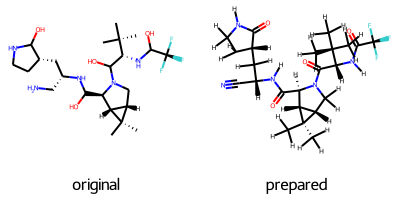

In [ ]:
smiles = "N#C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]1N(C[C@H]2[C@@H]1C2(C)C)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

#### Merge protein and ligand

In the next step, we want to merge the prepared protein and ligand structures using the Python package [MDTraj](https://github.com/mdtraj/mdtraj). [MDTraj](https://github.com/mdtraj/mdtraj) can handle the prepared protein, which is currently a [PDBFixer](https://github.com/openmm/pdbfixer) molecule, a format that has a topology and atom positions similar to and usually interchangeable with [OpenMM Modeller](http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing) topologies and positions. For the ligand however, we need to do several conversions, since it is currently an [RDKit](https://github.com/rdkit/rdkit) molecule.

In [ ]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: simtk.openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to Nanometers
    for atom in mol_positions:
        coords = atom / atom.unit
        atom = (coords / 10.0) * unit.nanometers  # since openmm works in nm

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [ ]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

Now protein and ligand are both in [OpenMM](https://github.com/openmm/openmm) like formats and can be merged with [MDTraj](https://github.com/mdtraj/mdtraj).

In [ ]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: simtk.openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: simtk.openmm.app.topology.Topology
        The merged topology.
    complex_positions: simtk.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [ ]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5886 atoms.


### MD simulation set up

We can now use the prepared complex to set up the MD simulation. 

### Force field

Common force fields like AMBER have parameters for amino acids, nucleic acids, water and ions and usually offer several options to choose from depending on your aim. We use the `amber14-all.xml` force field file, which is shipped with OpenMM and includes parameters for proteins, DNA, RNA and lipids. For solvation we use the standard three-site [water model](https://en.wikipedia.org/wiki/Water_model) [**TIP3P**](https://aip.scitation.org/doi/10.1063/1.445869).

Parameters for ligands however are not included. To generate these parameters, we can use the **G**eneral **A**MBER **F**orce**F**ield ([GAFF](http://ambermd.org/antechamber/gaff.html)), which is implemented in the Python package [OpenMM Forcefields](https://github.com/openmm/openmmforcefields). The following function generates a force field object holding standard AMBER parameters and additionally includes parameters for a small molecule if required.

In [ ]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: simtk.openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [ ]:
forcefield = generate_forcefield(rdkit_ligand)

### Solvation

Often, molecular systems are simulated in a box filled with solvent such as water. These boxes are of finite size, which results in problems for molecules at or near the box boundaries. With which molecules should those interact? Periodic boundary conditions can avoid such boundary artifacts by simulating a theoretically infinite system. Molecules at one boundary of the box thereby interact with molecules at the boundary on the other side of the box. This mimics a situation, in which the simulation box is surrounded by replicas of itself. When visualizing such MD simulations, one can often observe that particles leave the box at one side. However, they re-appear at the same time on the other side of the box with the same velocity. For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

![MD_water.gif](https://github.com/volkamerlab/teachopencadd/raw/d1ded86bb2c82ef088cc5145d0bcb997f6eab7dd/teachopencadd/talktorials/018_md_simulation/images/MD_water.gif)

Molecular dynamics simulation of water molecules with periodic boundary conditions (Kmckiern via [Wikimedia](https://commons.wikimedia.org/wiki/File:MD_water.gif)).

With our configured force field we can now  use the  [OpenMM Modeller](http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing) class to create the MD environment, a simulation box which contains the complex and is filled with a solvent. The standard solvent is water with a specified amount of ions. The size of the box can be determined in various ways. We define it with a padding, which results in a cubic box with dimensions dependent on the largest dimension of the complex.

> Note this step can take a long time, in the order of minutes, depending on your hardware.

In [ ]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

### System

With our configured force field we can now  use the  [OpenMM Modeller](http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing) class to create the MD environment, a simulation box which contains the complex and is filled with a solvent. The standard solvent is water with a specified amount of ions. The size of the box can be determined in various ways. We define it with a padding, which results in a cubic box with dimensions dependent on the largest dimension of the complex.

> Note this step can take a long time, in the order of minutes, depending on your hardware.

In [ ]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

Now we will save the system in xml and pdb format to perform the simulation at in a later lab.

In [ ]:
import openmm

F = open(os.path.join(lab_dir, 'MPro-nirmatrelvir-solv.xml'),'w')
F.write(openmm.openmm.XmlSerializer.serialize(system))
F.close()

with open(os.path.join(lab_dir, 'MPro-nirmatrelvir-solv.xml'), "w") as xml_file:
  xml_file.write(openmm.openmm.XmlSerializer.serialize(system))

with open(os.path.join(lab_dir, 'MPro-nirmatrelvir-solv.pdb'), "w") as pdb_file:  
  app.PDBFile.writeFile(
      simulation.topology,
      simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
      file=pdb_file,
      keepIds=True,
  )